In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import json
import os
import pandas as pd
import numpy as np

In [ ]:
!apt install texlive-extra-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-urw-base35
  ghostscript libalgorithm-c3-perl libauthen-sasl-perl libb-hooks-endofscope-perl
  libb-hooks-op-check-perl libclass-c3-perl libclass-c3-xs-perl libclass-data-inheritable-perl
  libclass-method-modifiers-perl libclass-xsaccessor-perl libcommon-sense-perl libdata-optlist-perl
  libdevel-callchecker-perl libdevel-caller-perl libdevel-globaldestruction-perl
  libdevel-lexalias-perl libdevel-stacktrace-perl libdist-checkconflicts-perl
  libdynaloader-functions-perl libemail-date-format-perl libeval-closure-perl
  libexception-class-perl libfile-homedir-perl libfile-which-perl libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libio-socket-ssl-perl libipc-shareable-perl libjbig2dec0 libjson-perl
  libjson-xs-perl libkpathsea6 liblog-dispatch-perl lib

## Read in data

In [ ]:
# download the raw data
!gdown https://drive.google.com/uc?id=1J6TeuyIDkpOBqQUL9ngmeO0sAVPZZgmL
!unzip "/content/multiple-flow.zip"

Downloading...
From: https://drive.google.com/uc?id=1J6TeuyIDkpOBqQUL9ngmeO0sAVPZZgmL
To: /content/multiple-flow.zip
100% 301k/301k [00:00<00:00, 13.2MB/s]
Archive:  /content/multiple-flow.zip
   creating: multiple-flow/
  inflating: multiple-flow/cubic_ECN_Prague_1_vs_N_N_vs_1_N_vs_N_srtt_data.json  
  inflating: multiple-flow/cubic_ECN_BBRv2_1_vs_N_N_vs_1_N_vs_N_tput_data.json  
  inflating: __MACOSX/multiple-flow/._cubic_ECN_BBRv2_1_vs_N_N_vs_1_N_vs_N_tput_data.json  
  inflating: multiple-flow/cubic_ECN_Prague_1_vs_N_N_vs_1_N_vs_N_tput_data.json  
  inflating: __MACOSX/multiple-flow/._cubic_ECN_Prague_1_vs_N_N_vs_1_N_vs_N_tput_data.json  
  inflating: multiple-flow/cubic_ECN_BBRv2_1_vs_N_N_vs_1_N_vs_N_srtt_data.json  


In [ ]:
#import shutil
#shutil.rmtree("/content/raw_data_updated", ignore_errors=True)
#shutil.rmtree("/content/__MACOSX/._raw_data_updated", ignore_errors=True)
#shutil.rmtree("/content/__MACOSX/raw_data_updated", ignore_errors=True)
#os.remove("/content/__MACOSX/._raw_data_updated")

FileNotFoundError: [Errno 2] No such file or directory: '/content/__MACOSX/._raw_data_updated'

**PRAGUE and L4S-Compatible BBRv2 vs CUBIC with ECN**

In [ ]:
# We will read all the data into a data frame

# Prepare an empty dataframe
df = pd.DataFrame(columns = ['LegacyCC', 'ECN', 'ECNThresh', 'Fallback', 'FlowType', 'BufferSize', 'BottleneckCap', 'BaseRTT', 'Queue', 'AccECN', 'Trial', 'Value', 'ValueType', 'str' ])

# Directory containing JSON files
data_directory = '/content/multiple-flow/'

# List of JSON files in the directory
json_files = [f for f in os.listdir(data_directory) if f.endswith('.json')]

#cubic_4.0_100_10_Codel_5_0_3_1_1_25_10


# Load data from each JSON file and update the variables - for throughput
for file_name in json_files:
    file_path = os.path.join(data_directory, file_name)
    with open(file_path, 'r') as f:
        data = json.load(f)

    for key, value in data.items():
      df = pd.concat( [df, pd.DataFrame({"LegacyCC": file_name.split("_")[0] ,
            "ScalableCC": file_name.split("_")[2],
            "ECN":       int(key.split("_")[-4]),
            "ECNThresh": key.split("_")[-7],
            "Fallback":  int(key.split("_")[-6]),
            #"FlowType":  "L4S" if "prague" in key else "Legacy",
            "FlowType": "L4S" if "prague" in key else ("ScalableBBRv2" if "bbr2" in key else "Legacy"),
            "BufferSize": float(key.split("_")[1]),
            "BottleneckCap": float(key.split("_")[2]),
            "BaseRTT":   float(key.split("_")[3]),
            "Queue":     "_".join(key.split("_")[4:-7]),
            "AccECN":    int(key.split("_")[-5]),
            "L4S_number": int(key.split("_")[-3]),
            "legacy_number": int(key.split("_")[-2]),
            "Trial":     int(key.split("_")[-1]),
            "Value":     float(value),
            "ValueType": "RTT" if "srtt" in file_name else "Throughput", 'str': key}, index=[0] )] )


<ipython-input-4-5b52305c4eda>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat( [df, pd.DataFrame({"LegacyCC": file_name.split("_")[0] ,


In [ ]:
# put the queue types in the correct order and give them the names we want
df.Queue = pd.Categorical(df.Queue, categories=["FIFO", "single_queue_FQ", "Codel", "FQ_Codel", 'FQ_Codel_L4S', "DualPI2"],
                      ordered=True)
df.Queue = df.Queue.map({'FIFO': 'FIFO',
              'single_queue_FQ': 'FIFO\n(+ECN)',
              'Codel': 'CoDel\n(+ECN+AQM)',
              'FQ_Codel': 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)',
              'FQ_Codel_L4S': 'FQ-Codel\n(+L4S Support)',
              'DualPI2': 'DualPI2\n(+ECN+AQM\n+DualQueue)'})

**Prague**

In [ ]:
# now make data frames with mean value for each metric
exp_factors = ['LegacyCC','ScalableCC','ECN', 'ECNThresh', 'Fallback', 'FlowType', 'BufferSize', 'BottleneckCap', 'BaseRTT', 'Queue', 'AccECN', "L4S_number", "legacy_number"]
df_rtt = df[df.ValueType=="RTT"].pivot_table(index=exp_factors, values=['Value'], aggfunc='mean').reset_index()
df_tpt = df[df.ValueType=="Throughput"].pivot_table(index=exp_factors, values=['Value'], aggfunc='mean').reset_index()

<ipython-input-6-e13a7c49fb38>:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_rtt = df[df.ValueType=="RTT"].pivot_table(index=exp_factors, values=['Value'], aggfunc='mean').reset_index()
<ipython-input-6-e13a7c49fb38>:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_tpt = df[df.ValueType=="Throughput"].pivot_table(index=exp_factors, values=['Value'], aggfunc='mean').reset_index()


## Plots for paper - Bar plots

In [ ]:
matplotlib.rc('xtick', labelsize=10.5)
matplotlib.rc('ytick', labelsize=10.5)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Prague vs Cubic with ECN

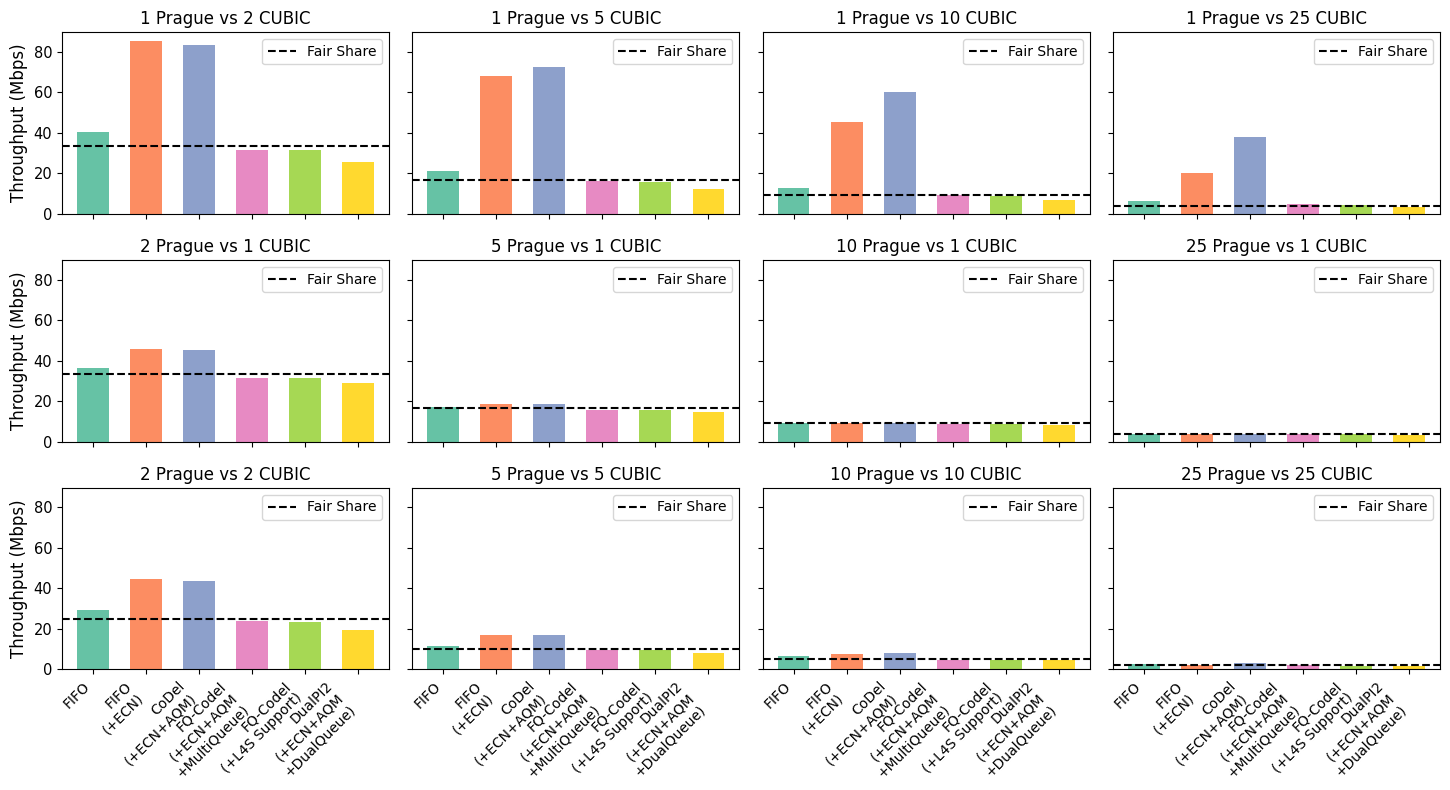

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_tpt_filtered = df_tpt[df_tpt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharey=True, sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_tpt_filtered[(df_tpt_filtered.LegacyCC == p['CC']) &
                                    (df_tpt_filtered.FlowType == 'L4S') &
                                    (df_tpt_filtered.ECN == p['ECN']) &
                                    (df_tpt_filtered.legacy_number == p['legacy_number']) &
                                    (df_tpt_filtered.L4S_number == p['L4S_number']) &
                                    (df_tpt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value'] / p['L4S_number']

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Throughput (Mbps)", fontsize=12)


        # Calculate and plot the fairness point
        fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')
        ax[row_idx, i].legend(loc='upper right', fontsize=10)


# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
plt.savefig("prague-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()


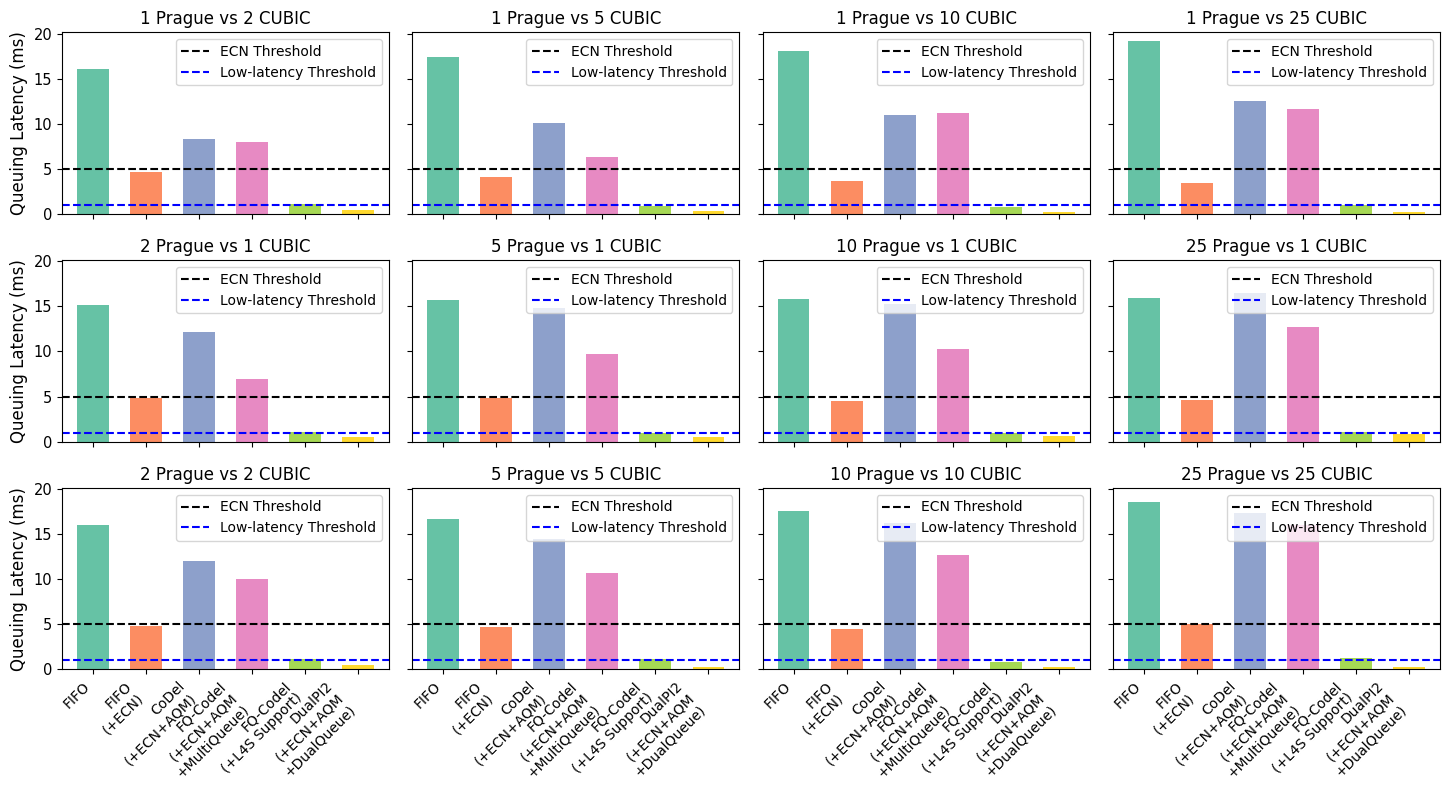

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_rtt_filtered = df_rtt[df_rtt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharey=True, sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_rtt_filtered[(df_rtt_filtered.LegacyCC == p['CC']) &
                                    (df_rtt_filtered.FlowType == 'L4S') &
                                    (df_rtt_filtered.ECN == p['ECN']) &
                                    (df_rtt_filtered.legacy_number == p['legacy_number']) &
                                    (df_rtt_filtered.L4S_number == p['L4S_number']) &
                                    (df_rtt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value']
        values = values - 10

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Queuing Latency (ms)", fontsize=12)


        # Calculate and plot the fairness point
        #fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        #ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')
        #ax[row_idx, i].legend(loc='upper right', fontsize=10)

        ecn_threshold = 5 # in ms
        low_latency_threshold=1 # in ms
        ax[row_idx, i].axhline(ecn_threshold, color='black', linestyle='--', linewidth=1.5, label=f'ECN Threshold')
        ax[row_idx, i].axhline(low_latency_threshold, color='blue', linestyle='--', linewidth=1.5, label=f'Low-latency Threshold')
        ax[row_idx, i].legend(loc='upper right', fontsize=10)

# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
#plt.savefig("prague-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()

### Different Scale for plots so that Fair Share is in middle. (Throughput)

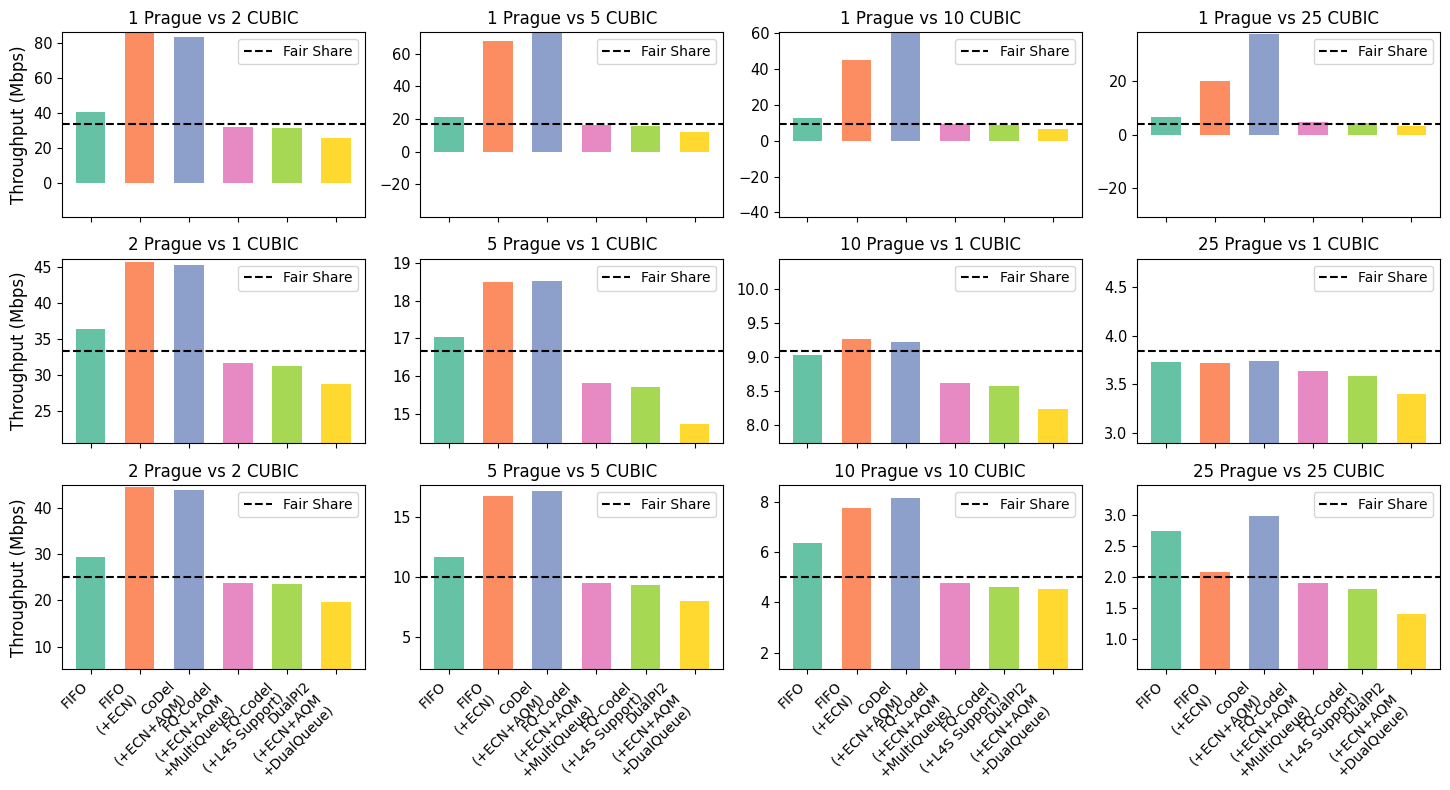

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_tpt_filtered = df_tpt[df_tpt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 Prague vsi 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_tpt_filtered[(df_tpt_filtered.LegacyCC == p['CC']) &
                                    (df_tpt_filtered.FlowType == 'L4S') &
                                    (df_tpt_filtered.ECN == p['ECN']) &
                                    (df_tpt_filtered.legacy_number == p['legacy_number']) &
                                    (df_tpt_filtered.L4S_number == p['L4S_number']) &
                                    (df_tpt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value'] / p['L4S_number']

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Throughput (Mbps)", fontsize=12)


        # Calculate and plot the fairness point
        fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')
        ax[row_idx, i].legend(loc='upper right', fontsize=10)

        # Adjust y-limits to center the fairness point
        y_data_min = values.min()
        y_data_max = values.max()

        # Compute the maximum absolute difference to the fairness point
        distance = max(abs(y_data_min - fairness_point), abs(y_data_max - fairness_point))

        # Set y-limits to center the fairness point
        y_min = fairness_point - distance - 0.5
        y_max = fairness_point + distance + 0.5
        ax[row_idx, i].set_ylim(y_min, y_max)




# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
#plt.savefig("prague-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()


**Different Scale v2**

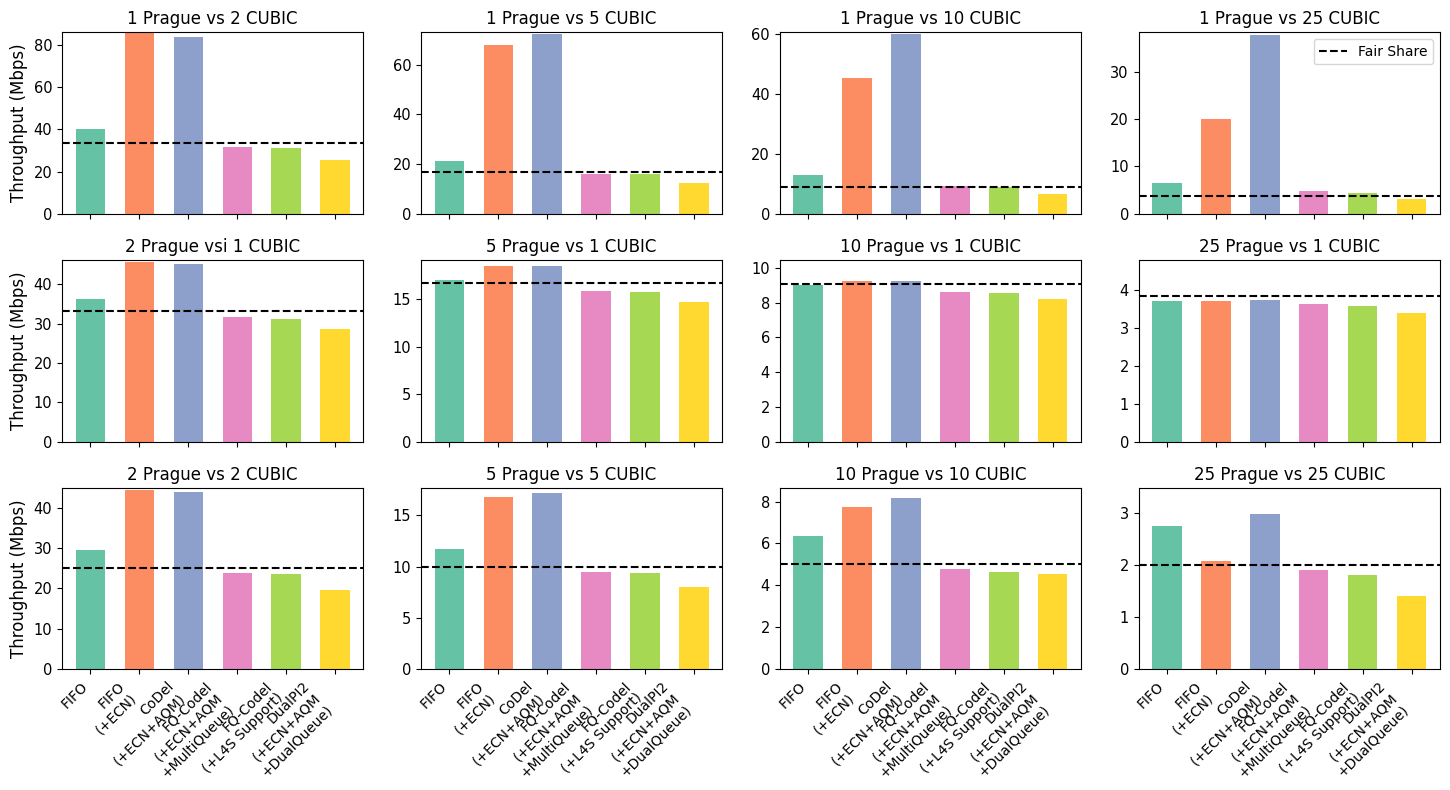

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_tpt_filtered = df_tpt[df_tpt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 Prague vsi 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 Prague vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 Prague vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 Prague vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 Prague vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 Prague vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_tpt_filtered[(df_tpt_filtered.LegacyCC == p['CC']) &
                                    (df_tpt_filtered.FlowType == 'L4S') &
                                    (df_tpt_filtered.ECN == p['ECN']) &
                                    (df_tpt_filtered.legacy_number == p['legacy_number']) &
                                    (df_tpt_filtered.L4S_number == p['L4S_number']) &
                                    (df_tpt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value'] / p['L4S_number']

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Throughput (Mbps)", fontsize=12)


        # Calculate and plot the fairness point
        fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')

        if i == 3 and row_idx==0:
          ax[row_idx, i].legend(loc='upper right', fontsize=10)

        # Adjust y-limits to center the fairness point
        y_data_min = values.min()
        y_data_max = values.max()

        # Compute the maximum absolute difference to the fairness point
        distance = max(abs(y_data_min - fairness_point), abs(y_data_max - fairness_point))

        # Set y-limits to center the fairness point
        y_min = 0
        y_max = fairness_point + distance + 0.5
        ax[row_idx, i].set_ylim(y_min, y_max)




# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
plt.savefig("prague-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()


### L4S-Compatible BBRv2 vs Cubic with ECN

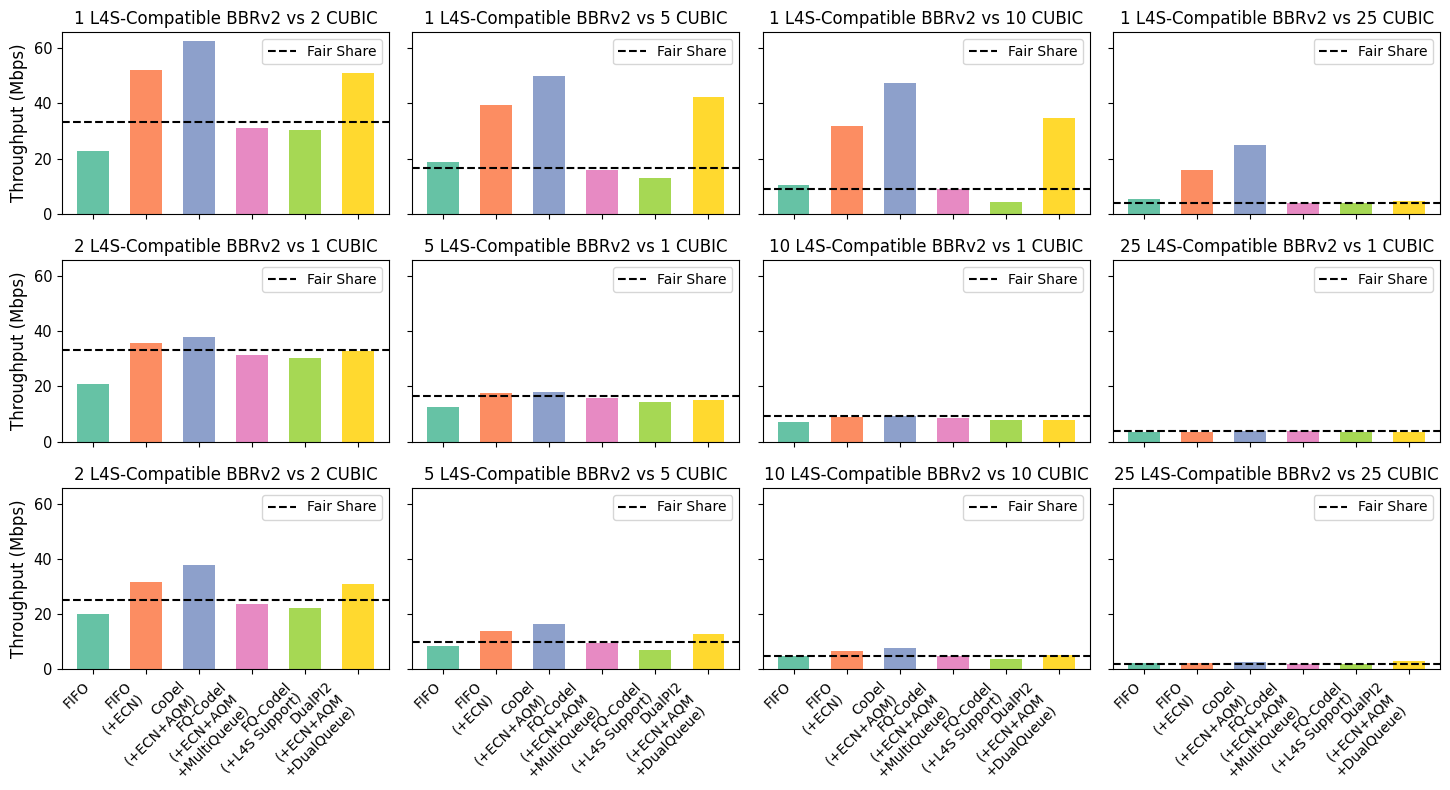

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_tpt_filtered = df_tpt[df_tpt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharey=True, sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_tpt_filtered[(df_tpt_filtered.LegacyCC == p['CC']) &
                                    (df_tpt_filtered.FlowType == 'ScalableBBRv2') &
                                    (df_tpt_filtered.ECN == p['ECN']) &
                                    (df_tpt_filtered.legacy_number == p['legacy_number']) &
                                    (df_tpt_filtered.L4S_number == p['L4S_number']) &
                                    (df_tpt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value'] / p['L4S_number']

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Throughput (Mbps)", fontsize=12)


        # Calculate and plot the fairness point
        fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')
        ax[row_idx, i].legend(loc='upper right', fontsize=10)

# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
plt.savefig("l4s-bbrv2-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()


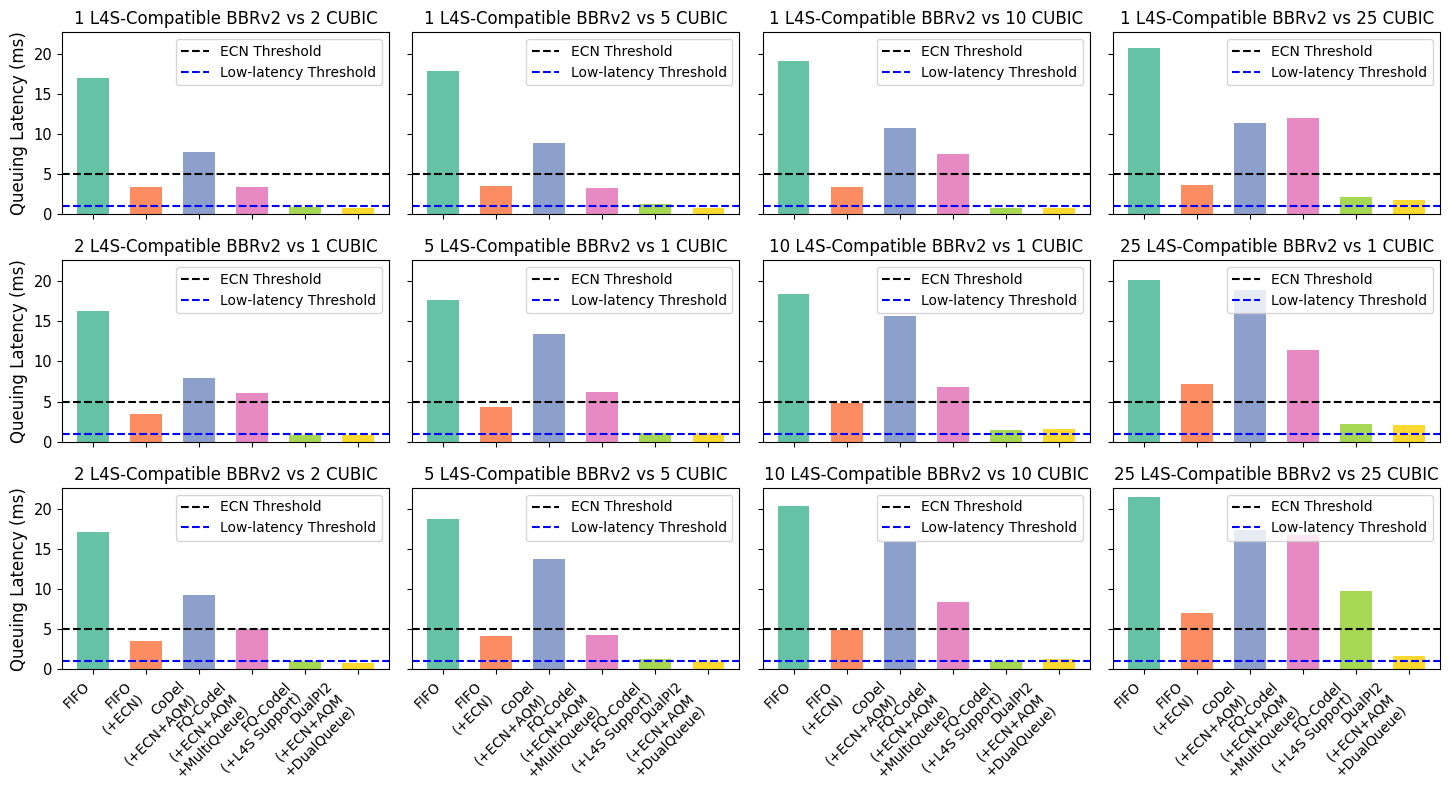

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_rtt_filtered = df_rtt[df_rtt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharey=True, sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_rtt_filtered[(df_rtt_filtered.LegacyCC == p['CC']) &
                                    (df_rtt_filtered.FlowType == 'ScalableBBRv2') &
                                    (df_rtt_filtered.ECN == p['ECN']) &
                                    (df_rtt_filtered.legacy_number == p['legacy_number']) &
                                    (df_rtt_filtered.L4S_number == p['L4S_number']) &
                                    (df_rtt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value']
        values = values - 10

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Queuing Latency (ms)", fontsize=12)


        # Calculate and plot the fairness point
        #fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        #ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')
        #ax[row_idx, i].legend(loc='upper right', fontsize=10)

        ecn_threshold = 5 # in ms
        low_latency_threshold=1 # in ms
        ax[row_idx, i].axhline(ecn_threshold, color='black', linestyle='--', linewidth=1.5, label=f'ECN Threshold')
        ax[row_idx, i].axhline(low_latency_threshold, color='blue', linestyle='--', linewidth=1.5, label=f'Low-latency Threshold')
        ax[row_idx, i].legend(loc='upper right', fontsize=10)

# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
#plt.savefig("l4s-bbrv2-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()


### Different Scale for plots so that Fair Share is in middle. (Throughput)

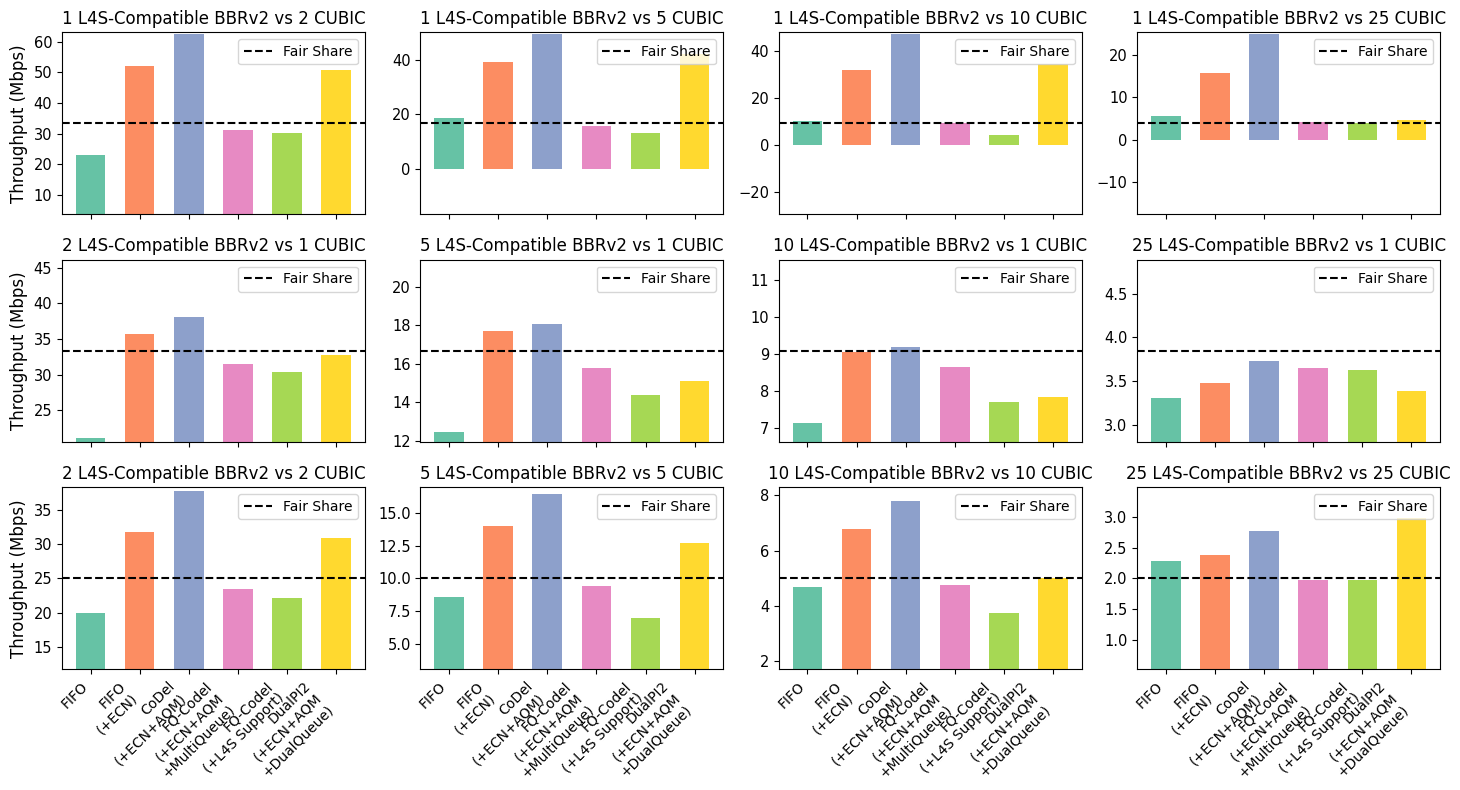

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_tpt_filtered = df_tpt[df_tpt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_tpt_filtered[(df_tpt_filtered.LegacyCC == p['CC']) &
                                    (df_tpt_filtered.FlowType == 'ScalableBBRv2') &
                                    (df_tpt_filtered.ECN == p['ECN']) &
                                    (df_tpt_filtered.legacy_number == p['legacy_number']) &
                                    (df_tpt_filtered.L4S_number == p['L4S_number']) &
                                    (df_tpt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value'] / p['L4S_number']

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Throughput (Mbps)", fontsize=12)


        # Calculate and plot the fairness point
        fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')
        ax[row_idx, i].legend(loc='upper right', fontsize=10)

        # Adjust y-limits to center the fairness point
        y_data_min = values.min()
        y_data_max = values.max()

        # Compute the maximum absolute difference to the fairness point
        distance = max(abs(y_data_min - fairness_point), abs(y_data_max - fairness_point))

        # Set y-limits to center the fairness point
        y_min = fairness_point - distance - 0.5
        y_max = fairness_point + distance + 0.5
        ax[row_idx, i].set_ylim(y_min, y_max)


# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
#plt.savefig("l4s-bbrv2-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()


**Different Scalev2**

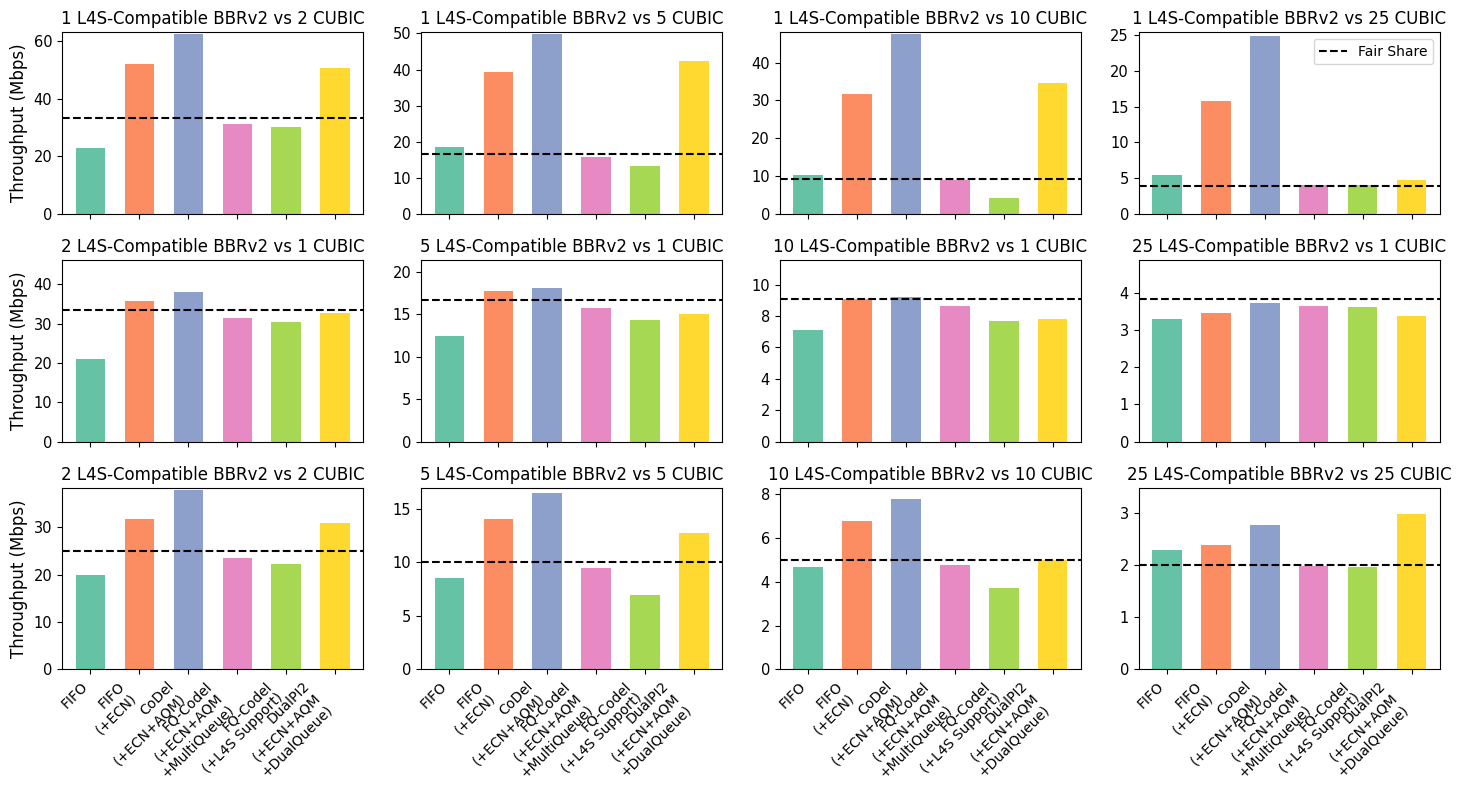

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Step 1: Filter the data for 2 BDP
df_tpt_filtered = df_tpt[df_tpt.BufferSize == 2]

# Define plots for 1 Prague vs N CUBIC
plots_1vsN = [{'title': '1 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 2},
              {'title': '1 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 5},
              {'title': '1 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 10},
              {'title': '1 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":1, "legacy_number": 25}]

# Define plots for N Prague vs 1 CUBIC
plots_Nvs1 = [{'title': '2 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 1},
              {'title': '5 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 1},
              {'title': '10 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 1},
              {'title': '25 L4S-Compatible BBRv2 vs 1 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 1}]

# Define plots for N Prague vs N CUBIC
plots_NvsN = [{'title': '2 L4S-Compatible BBRv2 vs 2 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":2, "legacy_number": 2},
              {'title': '5 L4S-Compatible BBRv2 vs 5 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":5, "legacy_number": 5},
              {'title': '10 L4S-Compatible BBRv2 vs 10 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":10, "legacy_number": 10},
              {'title': '25 L4S-Compatible BBRv2 vs 25 CUBIC', 'CC': 'cubic', 'ECN': 1, 'Fallback': 0, "L4S_number":25, "legacy_number": 25}]

# Define AQM labels
aqms = ['FIFO', 'FIFO\n(+ECN)', 'CoDel\n(+ECN+AQM)', 'FQ-Codel\n(+ECN+AQM\n+MultiQueue)', 'FQ-Codel\n(+L4S Support)', 'DualPI2\n(+ECN+AQM\n+DualQueue)']

# Step 2: Prepare the figure (3 rows for 1vsN, Nvs1, NvsN and 4 columns for the different subplots in each case)
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18, 12), sharey=True, sharex=True)
# Step 2: Prepare the figure (adjusted figure size)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14.6, 8), sharex=True)

# Step 3: Define a helper function to plot each set
def plot_subplots(plots, ax_row, row_idx, title_prefix):
    for i, p in enumerate(plots):
        # Filter the data for the specific plot settings
        plot_data = df_tpt_filtered[(df_tpt_filtered.LegacyCC == p['CC']) &
                                    (df_tpt_filtered.FlowType == 'ScalableBBRv2') &
                                    (df_tpt_filtered.ECN == p['ECN']) &
                                    (df_tpt_filtered.legacy_number == p['legacy_number']) &
                                    (df_tpt_filtered.L4S_number == p['L4S_number']) &
                                    (df_tpt_filtered.Fallback == p['Fallback'])]

        # Prepare data for bar plotting
        values = plot_data.set_index('Queue').reindex(aqms)['Value'] / p['L4S_number']

        # Create bar plots
        ax[row_idx, i].bar(aqms, values, color=sns.color_palette("Set2"), width=0.6)
        ax[row_idx, i].set_title(p['title'], fontsize=12)

        # Set y-axis label for the first subplot in each row
        if i == 0:
            #ax[row_idx, i].set_ylabel(f"{title_prefix} Throughput\n(Mbps)", fontsize=12)
            ax[row_idx, i].set_ylabel("Throughput (Mbps)", fontsize=12)


        # Calculate and plot the fairness point
        fairness_point = 100 / (p['L4S_number'] + p['legacy_number'])
        ax[row_idx, i].axhline(fairness_point, color='black', linestyle='--', linewidth=1.5, label=f'Fair Share')

        if i == 3 and row_idx==0:
          ax[row_idx, i].legend(loc='upper right', fontsize=10)

        # Adjust y-limits to center the fairness point
        y_data_min = values.min()
        y_data_max = values.max()

        # Compute the maximum absolute difference to the fairness point
        distance = max(abs(y_data_min - fairness_point), abs(y_data_max - fairness_point))

        # Set y-limits to center the fairness point
        y_min = 0
        y_max = fairness_point + distance + 0.5
        ax[row_idx, i].set_ylim(y_min, y_max)


# Step 4: Plot each row (1 Prague vs N CUBIC, N Prague vs 1 CUBIC, N Prague vs N CUBIC)
plot_subplots(plots_1vsN, ax, 0, "1 Prague vs N CUBIC")
plot_subplots(plots_Nvs1, ax, 1, "N Prague vs 1 CUBIC")
plot_subplots(plots_NvsN, ax, 2, "N Prague vs N CUBIC")

# Step 5: Set shared x-tick labels for the last row
for axs in ax[-1, :]:  # Only set x-tick labels in the last row
    axs.set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
    axs.set_xticklabels(aqms, rotation=45, ha="right", fontsize=10)  # Set the x-tick labels for all subplots



# Step 5: Set shared x-tick labels for the last row
ax[2, 0].set_xticks(np.arange(len(aqms)))  # Set the x-tick locations
ax[2, 0].set_xticklabels(aqms, rotation=45, ha="right")  # Set the x-tick labels for all subplots

plt.subplots_adjust(hspace=0.4, wspace=0.2)
# Step 6: Final adjustments and save
plt.tight_layout()
plt.savefig("l4s-bbrv2-vs-cubic-2BDP-1vsN-Nvs1-NvsN.pdf")
plt.show()
